In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [57]:
if kharpov:
    true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'phi': -.3,
               'scale': .1,
               'delta': 1.11,
               'rho': .2,
              }
else:
     true_params = {'equity_price': 0.47, 
               'vol_price': -.13,
               'phi': -.3,
               'scale': 2.50,
               'delta': 0.29,
               'rho': .83,
              }
    
time_dim = 1000
sim_dim = 1000
innov_dim = 1000

## Setup the linking functions.

In [58]:
true_params['phi']

-0.3

In [59]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(rho=true_params['rho'], scale=true_params['scale'], delta=true_params['delta'], 
                       phi=true_params['phi'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['vol_price'], theta=true_params['equity_price']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                  theta=true_params['equity_price']),
      'zeta': 1 - true_params['phi']**2})

In [60]:
# phi_val = .3
# true_params['equity_price']= vl.compute_theta(psi=total_true_params['psi'], scale=true_params['scale'],
#                                                              rho=true_params['rho'], zeta=1-phi_val**2)
# true_params['phi'] = phi_val
# print("Theta is {:.2f}".format(true_params['equity_price']))

In [61]:
total_true_params

{'equity_price': 0.5,
 'vol_price': -7,
 'phi': -0.3,
 'scale': 0.1,
 'delta': 1.11,
 'rho': 0.2,
 'gamma': 0.3107371790606361,
 'beta': 1.8216890076633052,
 'psi': -0.8660254037844386,
 'zeta': 0.91}

## We start by examining the distributions of simulated data

In [62]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

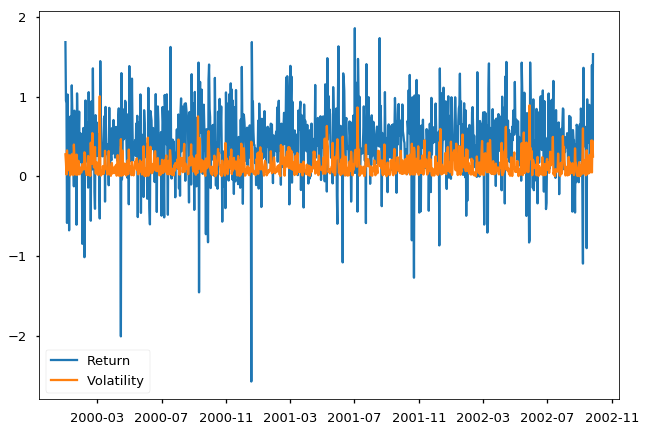

In [63]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()

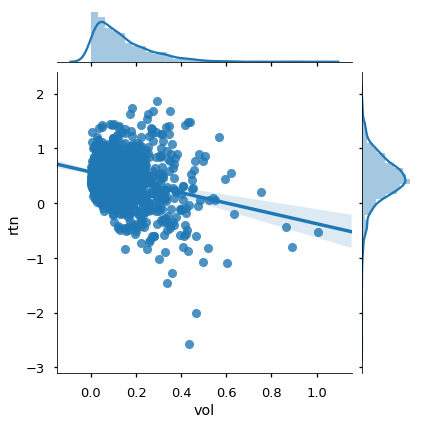

In [64]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [65]:
data.describe()

,vol,rtn
count,1000.000000,1000.000000
mean,0.140319,0.434906
std,0.126040,0.448958
min,0.000622,-2.577227
25%,0.046620,0.213387
50%,0.106499,0.444801
75%,0.200336,0.687534
max,1.005181,1.859730


## I now estimate all of the parameters

In [66]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [67]:
from functools import partial
import inspect

In [68]:
estimator = partial(vl.estimate_params_strong_id, case=2)

In [69]:
estimator(data)

({'gamma': 0.316722806939578,
  'beta': 1.825532159711221,
  'psi': -0.9917375104178222,
  'zeta': 0.9398009680042272,
  'delta': 1.2372211088061833,
  'rho': 0.1968724784041334,
  'scale': 0.09041325518965079,
  'phi': -0.2453549102744284,
  'equity_price': 0.7616318865239898},
                   beta     delta  equity_price     gamma       phi       psi  \
 beta          0.003463  0.000000           NaN -0.000378       NaN -0.000768   
 delta         0.000000  0.006011           NaN  0.000000       NaN  0.000000   
 equity_price       NaN       NaN      0.084826       NaN  0.023696       NaN   
 gamma        -0.000378  0.000000           NaN  0.000091       NaN -0.000272   
 phi                NaN       NaN      0.023696       NaN  0.007649       NaN   
 psi          -0.000768  0.000000           NaN -0.000272       NaN  0.009442   
 rho           0.000000 -0.000718           NaN  0.000000       NaN  0.000000   
 scale         0.000000 -0.000356           NaN  0.000000       NaN  0.0

In [70]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [71]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean   / np.sqrt(np.diag(cov) / data.vol.size)

In [72]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

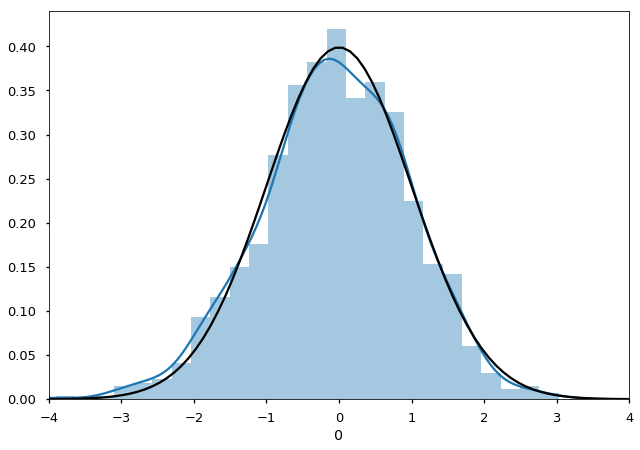

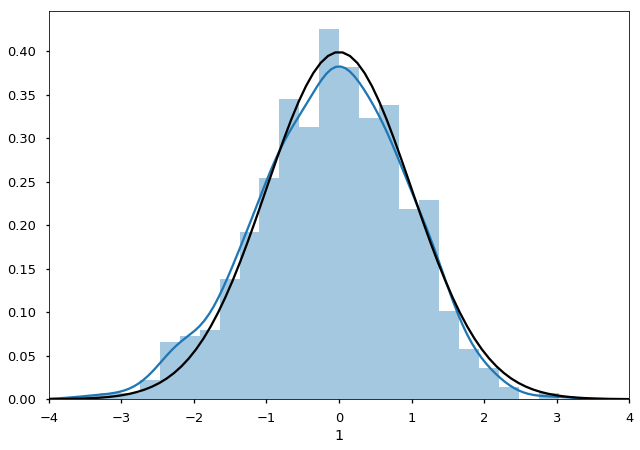

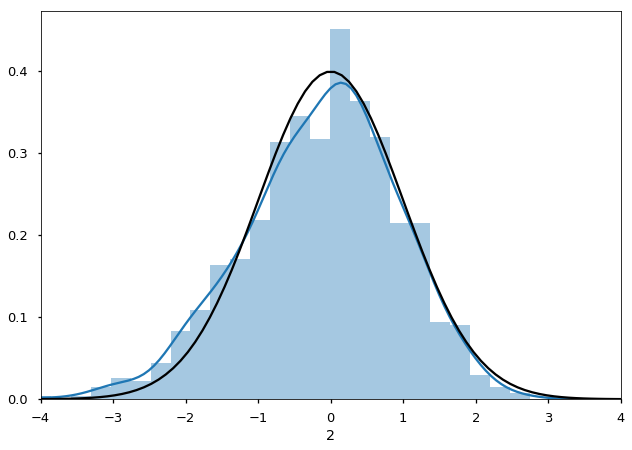

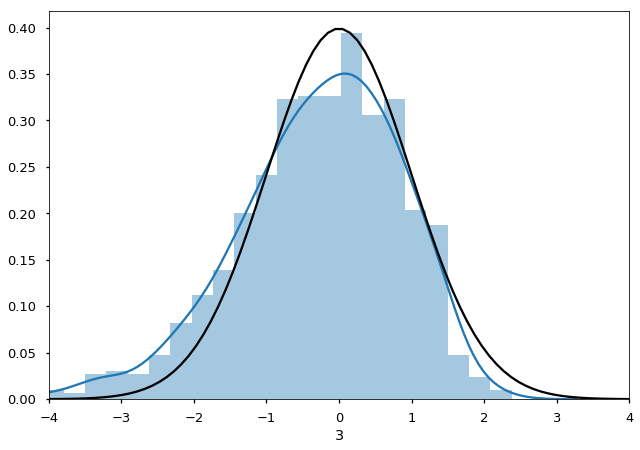

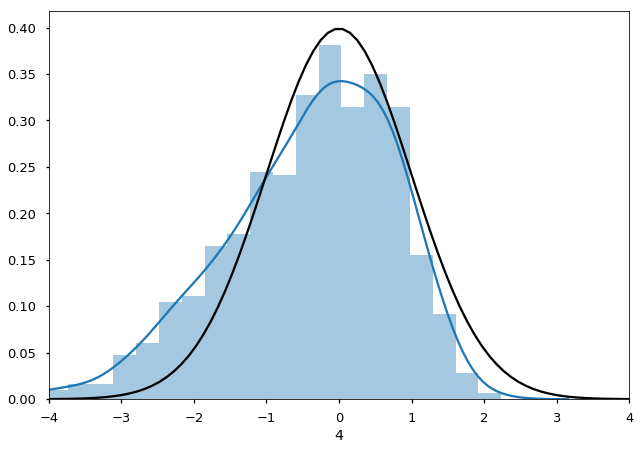

In [73]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

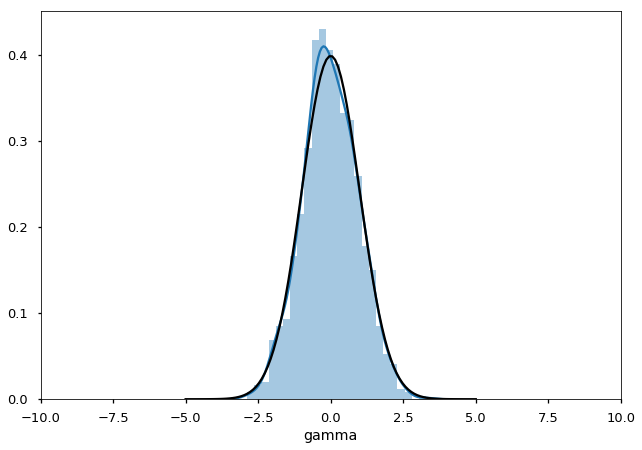

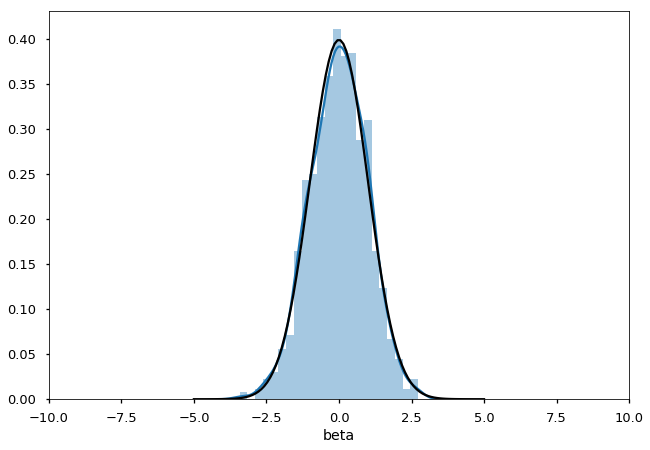

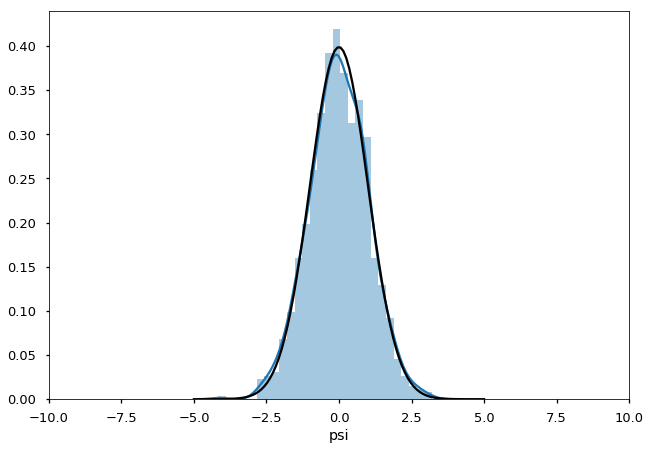

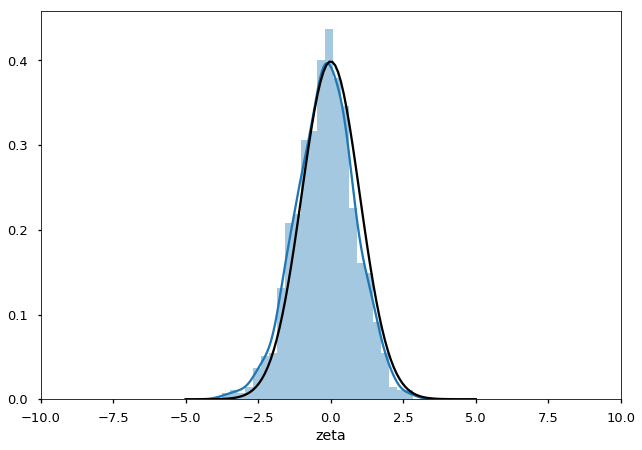

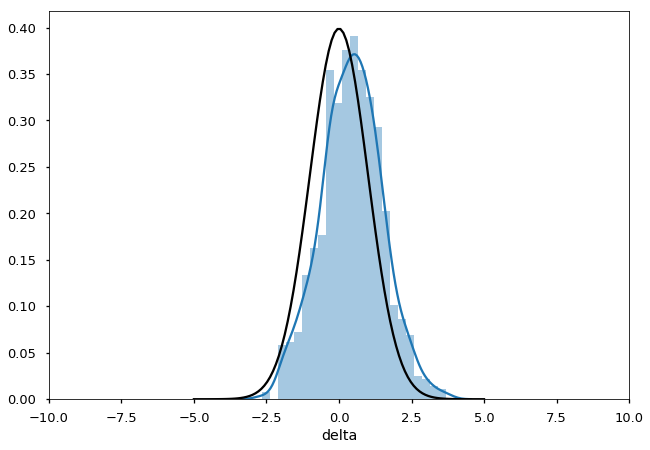

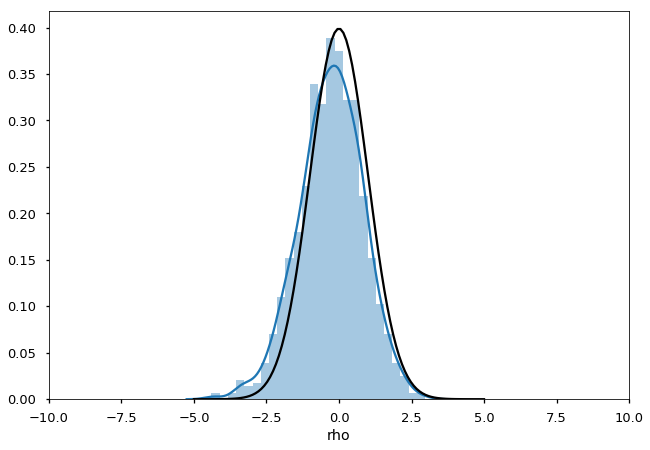

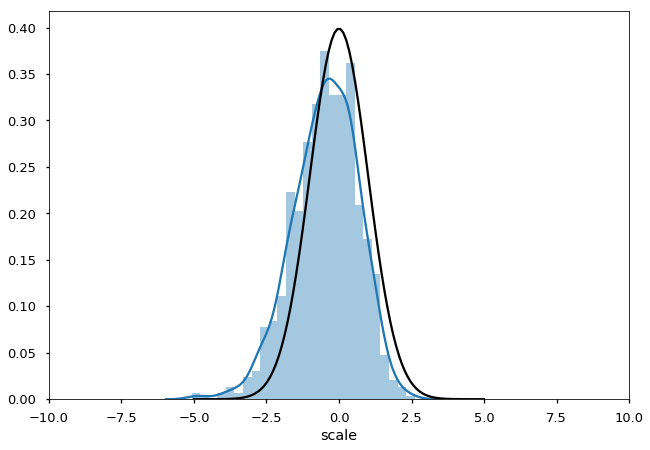

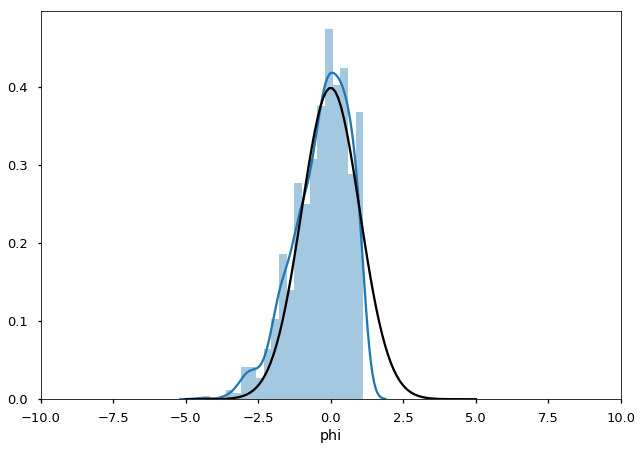

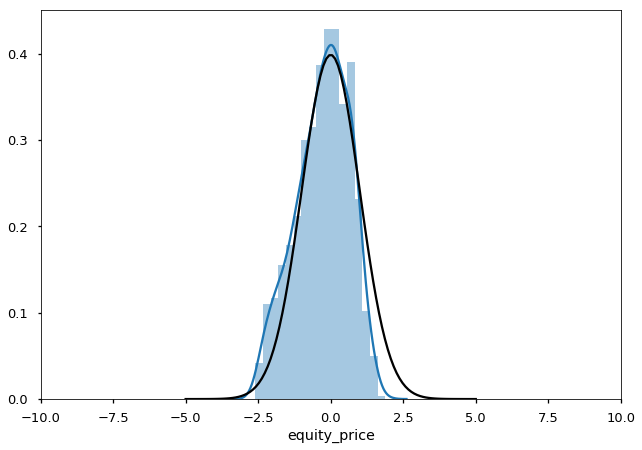

In [74]:
for name in est_arr[0][0].keys():
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name]) 
              for est, cov in est_arr]).replace(-np.inf, np.nan).replace(np.inf,np.nan).dropna().values, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    ax.set_xlabel(name)
    ax.set_xlim([-10,10])

# I now compute the robust conditional QLR statistic 

In [56]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05,
                                        robust_quantile=False)

TypeError: _lambdifygenerated() missing 1 required positional argument: 'theta'

In [ ]:
returnval.mean()

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}.json'.format(innov_dim, true_params['zeta'])
else:
    filename = '../results/reject_prop_{}_{}.json'.format(innov_dim, true_params['zeta'])
    
returnval.to_json(filename)

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.robust_qlr_qauntile, rug=True, kde_kws={"color": "orange", "lw": 3},
                 hist_kws={"color":'orange'}, ax=ax4, bins=np.arange(0, returnval.robust_qlr_qauntile.max(),.5),
                label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, rug=True, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3},
            rug_kws={'color':'blue'}, label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=2), color='black', label='Standard Quantile')
xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.pdf(x, df=2) for x in xvals], color='orange', label='$\chi^2(2)$ distribution')
ax4.set_xlim([0,20])
ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['zeta']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)